# T2A-LoRA

## Imports

In [1]:
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchaudio.transforms as T
from torchaudio.datasets import LIBRITTS

from voicestudio.utils.audio_utils import show_waveform

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio

### Check GPU Availability

In [2]:
!nvidia-smi

Mon Jan  5 01:32:38 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              1W /   78W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Set CUDA Device Number
DEVICE_NUM = 0

if torch.cuda.is_available():
    device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}")

INFO: Using device - cuda:0


## Datasets

In [ ]:
datasets = LIBRITTS(root="./data", url="train-clean-100", download=True)

In [ ]:
sample = datasets[0]
sample[3]

In [4]:
STYLE_PROMPTS = """
M_p-low_s-slow_e-low|Ask a low-pitched man to speak slowly with low energy;Ask a man to speak slowly with low volume and low pitch;Ask a man to speak slowly, his pitch and volume are low;Ask a man with a low pitch to speak slowly, his energy is low;Command a man with a high-pitched voice to speak slowly and with low energy;Command a man with a low pitch to speak slowly, his energy is low;Encourage a man with a high-pitched voice to speak slowly and with low energy;Instruct a man with a high-pitched voice to speak slowly and with low energy;Instruct a man with a low pitch to speak slowly, his energy is low;Request a man with a high-pitched voice to speak slowly and with low energy;Request a man with a low pitch to speak slowly, his energy is low;Tell a man with a low pitch to speak slowly, his energy is low;Urge a man with a high-pitched voice to speak slowly and with low energy;ask a low-pitched man to speak slowly with low energy;ask a man to speak slowly with low volume and low pitch;ask a man to speak slowly, his pitch and volume are both low;ask a man to speak slowly, his pitch and volume are low;ask a man to speak slowly, his voice is low in pitch and volume;ask a man to speak slowly, his voice is low-pitched and low-volume;let a high-pitched man to speak slowly with low energy;request a man to speak slowly, his pitch and volume are low
M_p-low_s-slow_e-normal|A man at low speaking speed and low pitch speaks with normal volume;A man spoke slowly with normal volume and low pitch;A man with a low pitch spoke slowly and at a normal decibel level;A man with a low pitch spoke slowly and at a normal volume;A man with a low pitch spoke slowly and with a normal volume;A man with a low pitch spoke slowly with normal volume;A man with a low-pitched voice speaks slowly and at a normal decibel level;A man with a low-pitched voice speaks slowly and at a normal volume;A man with a low-pitched voice speaks slowly and with a normal decibel level;A man with a low-pitched voice speaks slowly and with a normal sound level;A man with a low-pitched voice speaks slowly and with a normal volume;A man with a low-pitched voice spoke slowly with normal volume;A man with low pitch and normal energy speaks slowly;A man with low pitch and normal volume speaks slowly;A man with low pitch and slow speaking speed speaks at a normal volume;A man with low pitch and slow speaking speed speaks at a normal volume level;A man with low pitch and slow speaking speed speaks with a normal sound level;A man with low pitch and slow speaking speed speaks with a normal volume;A man with low pitch and slow speaking speed speaks with normal volume;A man with low pitch said slowly with normal volume;A man with low pitch speaks slowly with normal volume;A man with low pitch spoke slowly with normal volume;Ask a low-pitched man to speak slowly but in normal volume;Ask a man to speak slowly with normal volume and low pitch;This man speaks slowly with low pitch and normal volume;ask a low-pitched man to speak slowly but in normal volume;ask a man to speak slowly with normal volume and low pitch;this man speaks slowly with low pitch and normal energy
M_p-low_s-slow_e-high|A gentleman speaks slowly with low pitch and loudly;A gentleman with a deep voice speaks slowly and loudly;A gentleman with a slow and loud voice speaks with a low pitch;A low-pitched male said slowly and loudly;A man speaks slowly and loudly with low pitch and high volume;A man speaks slowly with low pitch and high volume;A man with a low pitch speaks slowly and loudly;A man with a low voice speaks slowly and loudly;A man with a low-pitched voice speaks slowly and loudly;A man with a low-pitched voice spoke slowly and loudly;A man with a low-pitched voice spoke slowly and with a loud tone;A man with a low-pitched voice spoke slowly and with great volume;A man with low pitch and high volume speaks slowly;A man with low pitch and high volume speaks slowly and loudly;A man with low pitch and slow speed speaks loudly;A man with low pitch speaks slowly and loudly;A man with low pitch speaks slowly and loudly with high energy;A man with low pitch speaks slowly and with high energy;A man with low pitch speaks slowly and with high intensity;A man with low pitch speaks slowly and with high volume;A slow-speaking man with low pitch speaks loudly;He speaks loudly with slow speaking speed and low pitch;ask a man to speak slowly with low pitch and high volume;let a low-pitched man speak slowly but in high energy
M_p-low_s-normal_e-low|A low-pitched male speaks in low pitch and low volume;A low-pitched male voice speaks with standard speed and low energy;A low-pitched male voice speaks with standard speed and low volume;A male character speaks in low pitch and low volume;A male individual speaks in low pitch and low volume;A male person speaks in low pitch and low volume;A male speaks in low pitch and low volume;A male speaks with a low pitch, normal speed and low volume;A male speaks with low pitch and normal speed;A male voice is low-pitched and low-energy;A male voice speaks in low pitch and low volume;A male voice speaks with low pitch, normal speed and low volume;A male with low-pitched voice speaks in low volume and low pitch;A man speaks in low pitch and low volume;A man speaks with a low pitch, normal speed and low volume;A man speaks with low pitch and low volume;A man speaks with low pitch, normal speed and low volume;A man with low-pitched voice speaks in low volume and low pitch;A man with low-pitched voice speaks with standard speaking speed and low volume;A man with low-pitched voice speaks with standard speed and low energy;A man with low-pitched voice speaks with standard speed and low volume;A man's voice speaks with low pitch, normal speed and low volume;He speaks with a low-pitched voice and low volume;He talks with low pitch, low energy and normal speaking speed;a low-pitched man speaks with standard speaking speed and low energy;ask a man to speak with low pitch, normal speed and low volume
M_p-low_s-normal_e-normal|A man with a low pitch says in normal volume and normal speaking speed;A man with a low pitch speaks in normal volume and normal speed;A man with a low pitch speaks in normal volume and normal talking speed;A man with a low voice level speaks at a normal volume and normal pace;A man with a low-pitched voice speaks with normal volume and normal rate;Ask a low-pitched man to speak normally with standard speed and volume;Ask a low-pitched man to speak with normal speed and normal energy;Ask a man to speak in a low pitch, normal speed, and normal energy;Ask a man to speak in low pitch, normal speed and normal energy;Ask a man with a low pitch to speak at a normal speed and energy level;Ask a man with a low pitch to speak at a normal volume and speed;Command a man to speak in a low pitch, normal speed, and normal energy;Command a man with a low pitch to speak with normal speed and volume;Direct a man with a low pitch to speak with normal speed and energy;Instruct a man to speak in a low pitch, normal speed, and normal energy;Instruct a man with a low-pitched voice to speak at a standard speed and volume;Instruct a man with a low-pitched voice to speak with normal speed and energy;Let a man speak with a low pitch, normal volume and normal talking speed;Request a man to speak with a low pitch, normal speed, and normal energy;Request a man with a low-pitched voice to speak with normal speed and energy;Request a man with a low-pitched voice to speak with standard speed and volume;Tell a man to speak with a low pitch, normal speed, and normal energy;Tell a man with a low pitch to speak with normal speed and energy;Tell a man with a low pitch to speak with normal speed and volume;ask a low-pitched man to speak normally with standard speed and volume;ask a low-pitched man to speak with normal speed and normal energy;ask a man to speak in low pitch, normal speed and normal energy
M_p-low_s-normal_e-high|A man who has a loud voice, low pitch and normal speed;A man who have a loud voice but low pitch and normal speed;A man who speaks with a loud voice but low pitch and normal speed;A man who speaks with a loud voice, low pitch and normal speed;A man with a loud sound, ask him to speak with low pitch and normal speed;A man with a loud sound, ask him to speak with low pitch and normal speed, please;A man with a loud voice and low pitch, speaking at a normal speed;A man with a loud voice but low pitch and normal speed;A man with a loud voice, low pitch and normal speed;Ask a man to speak with a loud voice but a low pitch and normal speed;Ask a man to speak with a loud voice but a low pitch with standard speaking speed;Ask a man to speak with a loud voice but low pitch and normal speed;Ask a man to speak with a low pitch, normal speed and high energy;Ask a man to speak with low pitch and normal speed, with a loud sound;Ask a man with a loud sound to speak with low pitch and normal speed;Command a man to speak with a low pitch, normal speed and high energy;Command a man to speak with low pitch, normal speed and high energy;Instruct a man to speak loudly but with a low pitch and normal speed;Instruct a man to speak with a low pitch, normal speed and high energy;Request a man to speak with a loud sound but a low pitch and normal speed;Request a man to speak with a low pitch, normal speed and high energy;Speak with a loud sound, ask a man to speak with low pitch and normal speed;Tell a man to speak loudly but with a low pitch and normal speed;Tell a man to speak with a low pitch, normal speed and high energy;ask a man to speak with low pitch, normal speed and high energy;ask a man with a loud sound to speak with low pitch and normal speed;tell a man to speak loudly but pitch is low with normal speaking speed
M_p-low_s-fast_e-low|Ask a low-pitched male to speak quickly and in a low volume;Ask a low-pitched male to speak quickly and in small volume;Ask a low-pitched male to speak quickly and with low volume;Ask a low-pitched male with fast speaking speed and small volume;Ask a low-pitched man to speak quickly and in small volume;Ask a low-pitched man to speak quickly and with low volume;Ask a low-pitched man to speak quickly with small energy;Ask a low-pitched man with fast speaking speed and small volume;Ask a man to speak fast but with low pitch and low volume;Ask a man to speak quickly with a low pitch and low volume;Command a man to speak fast with a low pitch and low volume;Direct a low-pitched male to speak quickly and with a small voice;Direct a man to speak quickly with a low pitch and low volume;Instruct a low-pitched male to speak quickly and with a small volume;Instruct a man to speak quickly with a low pitch and low volume;Request a man to speak fast with a low pitch and low volume;ask a low-pitched male to speak quickly and in small volume;ask a low-pitched male to speak quickly and with low volume;ask a low-pitched man with fast speaking speed and small volume;ask a man to speak fast but with low pitch and low volume
M_p-low_s-fast_e-normal|A low-pitched male speaks fast with normal volume;A low-pitched voice speaks fast with normal power;A male with a low-pitched voice speaks quickly and with normal power;A male with a low-pitched voice speaks rapidly and with normal intensity;A man speaks quickly with a low pitch and normal volume;A man with a low pitch speaks fast with normal volume;A man with a low-pitched voice speaks fast and at a normal loudness;A man with low pitch speaks quickly and at a normal volume;Ask a man to speak with a low pitch and fast speaking speed, while maintaining normal power;Ask a man to speak with low pitch and fast speed, while maintaining a normal volume;Ask a man to speak with low pitch, fast speaking speed and normal power;Ask a man with low pitch to speak quickly, but maintain a normal energy level;Command a man to speak with a low pitch and a fast speaking speed, while keeping the volume normal;Command a man with a low-pitched voice to speak quickly, but keep his energy level normal;Direct a man to speak quickly, with a low pitch and a normal volume;Direct a man to speak with a low pitch, fast speaking speed, and normal power;He speaks fast with a low pitch and normal power;He speaks fast with low pitch and normal power;Instruct a man to speak at a fast pace, while keeping his pitch low and his volume normal;Instruct a man to speak with a low pitch, fast speaking speed, and normal power;Request a man to speak quickly, but with a low pitch and a normal volume;Request a man to speak with a low-pitched voice, fast speech, and normal volume;Request a man with a low-pitched voice to speak rapidly, while keeping his energy level normal;Tell a man to speak with a low-pitched voice, fast speech, and normal volume;Tell a man with a low-pitched voice to speak fast, but maintain a normal energy level;ask a low-pitched man to speak fast but in normal energy;ask a man to speak fast but with low pitch and normal volume;ask a man to speak with low pitch, fast speaking speed and normal power
M_p-low_s-fast_e-high|A low-pitched male speaks fast with high power;A male with a low-pitched voice speaks fast and with high energy;A male with a low-pitched voice speaks fast and with high intensity;A man with a low voice speaks fast and loudly;A man with a low voice speaks fast and with high volume;A man with a low voice speaks quickly and loudly;A man with a low voice speaks quickly and loudly with high energy;A man with a low voice speaks quickly and with high amplitude;A man with a low voice speaks quickly and with high energy;A man with a low voice speaks quickly and with high power;A man with a low voice speaks quickly and with high volume;A man with a low voice speaks quickly and with high volume and energy;A man with a low-pitched voice speaks fast and loudly with high energy;A man with a low-pitched voice speaks fast and with high energy;Ask a man to speak quickly and loudly with a low pitch;Ask a man to speak with a low pitch and high energy, but quickly and loudly;Ask a man to speak with a low pitch and high volume, but quickly;Ask a man to speak with a low voice and high energy, but fast and loudly;Ask a man to speak with a low voice and high volume, but fast;Ask a man with a low voice to speak quickly and loudly;He speaks loudly with fast talking speed and low pitch;a low-pitched man speaks with fast speaking speed and high energy;ask a man to speak fast but low pitch and high volume;ask a man with low voice to speak quickly and loudly
M_p-normal_s-slow_e-low| ask a man to speak slowly with normal pitch and low energy;Ask a man to say at a low volume of speech at a slower speaking speed;Ask a man to use a normal pitch and low volume to say slowly;Ask a man to use a normal pitch and low volume to say slowly, please;Ask a man to use normal pitch and low volume to say slowly;Can I ask a man to speak slowly with normal pitch and low energy?;Can I ask a man to speak slowly with normal pitch and low volume?;Can I ask a man to speak slowly, with normal pitch and low volume?;Can I inquire about asking a man to speak at a low volume, normal pitch, and a slower speed of sound?;Can I request a man to speak at a low volume with a normal pitch and a slow speed of sound?;Can I request a man to use normal pitch and low volume to say slowly?;Can you ask a man to speak at a low volume with a slower pitch and a low speed of sound?;Can you ask a man to speak at a low volume with a slower speed of sound?;Can you ask a man to speak slowly with normal pitch and low energy?;Can you ask a man to use a low volume of speech with a slower speaking speed?;Can you kindly ask a man to speak slowly with normal pitch and low energy?;Is it okay to request a man to say something at a low volume, normal pitch, and a slower speed of sound?;Is it possible to ask a man to say at a low volume with normal pitch and a slow speed of sound?;Is it possible to ask a man to say something at a low volume, normal pitch, and slow speed?;May I ask a man to say at a low volume with a slower speaking rate?;May I ask a man to speak at a low volume with normal pitch and a slower speaking speed?;May I ask a man to use a normal pitch and low volume to say slowly?;May I inquire a man to use a normal pitch and low volume to say slowly?;May I request a man to speak at a low volume with normal pitch and a slow speed of sound?;May I request a man to speak slowly with a low volume of sound?;May I request a man to use a normal pitch and low volume to say slowly?;May i ask a man to say at a low volume at a normal pitch and a low speed of sound;May i ask a man to say at a low volume with normal pitch and a slow speed of sound;Would you ask a man to speak slowly with normal pitch and low energy?;Would you mind asking a man to speak slowly with normal pitch and low energy?;ask a man to speak slowly with normal pitch and low energy
M_p-normal_s-slow_e-normal|A man speaks in a normal pitch slowly with normal volume;A man speaks slowly with normal pitch and normal volume;A man speaks slowly with normal pitch and volume;A man speaks slowly, with a normal pitch and a normal volume;A man speaks slowly, with a normal pitch and volume;A man speaks slowly, with normal pitch and volume;A man speaks with a normal pitch and normal volume, but slowly;A man speaks with a normal pitch and slow speed;A man speaks with a slow speed, a normal pitch and volume;A man speaks with a slow speed, normal pitch and volume;A man speaks with slow speaking speed, normal pitch and normal volume;A man spoke slowly with a normal volume and standard pitch;A man spoke slowly with a standard volume and normal pitch;Ask a man to speak slowly but with normal pitch and normal volume;This man said slowly with standard volume and normal pitch;This man spoke slowly with a normal volume and standard pitch;This man spoke slowly with a standard volume and normal pitch;a man speaks with slow speaking speed, normal pitch and normal volume;ask a man to speak slowly but with normal pitch and normal volume;this man said slowly with standard volume and normal pitch
M_p-normal_s-slow_e-high|Ask a man to speak with a normal pitch and slow talking speed, and high energy;Ask a man to speak with normal pitch and slow talking speed, and high energy;Ask a man to speak with normal pitch, slow talking speed and high energy;Ask a man with a loud voice and say a word slowly;Ask a man with a loud voice to articulate slowly;Ask a man with a loud voice to pronounce slowly;Ask a man with a loud voice to say slowly;Ask a man with a loud voice to speak slowly;Ask a man with loud sound to articulate slowly;Ask a man with loud sound to pronounce slowly;Ask a man with loud sound to say slowly;Ask a man with loud sound to speak slowly;Ask a man with loud voice to say slowly;Let a man speak slowly with high energy and normal pitch;Let a man with high energy and normal pitch speak slowly;Request a man with a loud voice to say a word slowly;ask a man to speak with normal pitch, slow talking speed and high energy;let a man speak slowly with high energy and normal pitch
M_p-normal_s-normal_e-low|He speaks quietly, but his speech has a normal pitch and a standard talking speed;He speaks with a low volume, but his speech has a normal pitch and a standard talking speed;He speaks with a low volume, but his speech has a normal pitch and normal speaking speed;He speaks with a low volume, but his speech is at a standard pace;He speaks with a low volume, but his speech is normal;He speaks with low energy, but the pitch is normal and the speed is standard;He speaks with low volume, but the pitch is normal and the speed is standard;He speaks with low volume, but the speed is normal;he speaks with low volume but speaks normally with standard speaking speed;ask a man to speak with low energy but normal pitch and normal speaking speed;he speaks with low volume but the speech has normal pitch and standard talking speed;he speaks with low volume, but his speech has normal pitch and normal speaking speed;his voice is small in volume, but the speed is normal
M_p-normal_s-normal_e-normal|A man speaks in average speaking speed with a normal pitch and normal volume;A man speaks with a normal pitch, speed, and volume;A man speaks with a normal volume, average speaking speed, and normal pitch;A man speaks with a normal volume, normal pitch, and average speaking speed;A man speaks with a normal volume, normal speaking speed, and normal pitch;A man speaks with a normal volume, standard pitch, and normal speaking speed;A man speaks with a normal volume, standard speaking speed, and normal pitch;A man speaks with a regular pitch, speed, and volume;A man speaks with a standard pitch, speed, and volume;A man speaks with a typical pitch, speed, and volume;A man speaks with an average pitch, speed, and volume;A man speaks with average pitch, normal volume and average speaking speed;A man speaks with normal pitch, average speaking speed and normal volume;A man speaks with normal volume, average pitch and normal speaking speed;A man speaks with normal volume, average speaking speed and standard pitch;A man speaks with normal volume, normal pitch and average talking speed;A man speaks with normal volume, normal pitch and normal talking speed;A man speaks with normal volume, normal pitch and regular talking speed;A man speaks with normal volume, normal pitch and standard talking speed;A man speaks with normal volume, normal pitch and typical talking speed;A man speaks with normal volume, standard pitch and average speaking speed;A man speaks with normal volume, standard speaking speed and normal pitch;ask a man to speak normally with normal pitch, speed, and volume
M_p-normal_s-normal_e-high| ask a man to speak normal pitch, normal speed and high energy;A man speaks with high volume and normal pitch, speaking at a normal speed;A man speaks with high volume, normal pitch, and a normal speaking speed;A man speaks with high volume, normal pitch, and a speed that is normal;A man speaks with high volume, normal pitch, and a speed that is typical;A man speaks with high volume, normal pitch, and normal speaking speed;He said loudly with normal speed and high pitch;He speaks loudly with normal speed and high pitch;He speaks with a high volume, normal speed and a high pitch;He speaks with high energy, normal pitch and normal speed;He speaks with high volume and normal speed, with a high pitch;He speaks with normal pitch and high energy, at a normal speed;He speaks with normal pitch and normal speed, but with high energy;He speaks with normal pitch, high energy and normal speed;He speaks with normal pitch, normal speed and high energy;He spoke loudly with normal speed and a high pitch;He spoke loudly with normal speed and high pitch;He spoke loudly, with normal speed and a high pitch;He spoke loudly, with normal speed and a high-pitched voice;He spoke with a loud voice and normal speed, with a high pitch;He spoke with high volume and normal speed, with a high pitch;a man speaks with high volume but normal pitch and normal speaking speed
M_p-normal_s-fast_e-low|Ask a man to speak fast with normal pitch and low energy;Ask a man to speak quickly with a normal pitch and low energy;Ask a man to speak quickly with low energy and standard pitch;Ask a man to speak quickly, with a normal pitch and low energy;Ask a man to speak with a normal pitch and a fast speaking speed, while keeping the energy low;Ask a man to speak with a normal pitch, but speak quickly and with low energy;Ask a man to speak with a normal pitch, but with a fast speaking speed and low energy;Ask a man to speak with a normal pitch, but with a fast speaking speed and low volume;Ask a man to speak with a normal pitch, but with a quick pace and low volume;Ask a man to speak with a normal pitch, but with a quick tempo and low volume;Ask a man to speak with a standard pitch, but with a fast pace and low energy;Ask a man to speak with a standard pitch, but with a quick pace and low energy;He speaks with a fast speaking speed and normal pitch and low volume;He speaks with a low volume and fast speaking speed and normal pitch;He speaks with a normal pitch and fast speaking speed and low volume;He speaks with a normal pitch and low volume, and his speaking speed is fast;He speaks with fast speaking speed and normal pitch and low volume;His pitch is normal, but his speaking speed is fast and his volume is low;His pitch is normal, but his speaking speed is fast, and his volume is low;His pitch is normal, but the speed is fast, and the volume is low;His speaking speed is fast, and his pitch is normal, and his volume is low;ask a man to speak fast with normal pitch and low energy;ask a man to speak quickly with low energy and standard pitch;he speaks with fast speaking speed and normal pitch and low volume
M_p-normal_s-fast_e-normal| a man speaks quickly with standard pitch and standard energy;A male voice speaks fast with normal pitch and normal volume;A male who speaks quickly has normal pitch and volume;A male's pitch and volume are typical when he speaks quickly;A man speaks quickly with a normal pitch and standard energy;A man speaks quickly with a normal pitch and standard volume;A man speaks quickly with a standard pitch and normal energy;A man speaks quickly with a standard pitch and normal volume;A man speaks quickly with a standard pitch and standard energy;A man speaks quickly with normal pitch and normal volume;A man speaks quickly with normal pitch and standard volume;A man speaks quickly with standard pitch and standard energy;A man's pitch and volume are normal when he speaks quickly;A man's pitch and volume are standard when he speaks quickly;A man's voice that speaks quickly has a normal pitch;A man's voice that speaks quickly is normal in pitch;A quick-talking man's voice is normal in pitch;Ask a male to speak quickly, his pitch and volume are normal;Ask a man to speak quickly, his pitch and volume are normal;Let a man speak fast with normal pitch and normal volume;Let us use the voice of a fast speaking man, his pitch is normal;Let's use a man's voice that speaks quickly and has a normal pitch;Let's use a man's voice that speaks quickly and has a normal pitch and volume;This man speaks quickly with normal pitch and standard volume;When a male speaks quickly, his pitch and volume remain normal;ask a male to speak quickly, his pitch and volume are normal;ask a man to speak fast but with normal pitch and normal volume;let us use the voice of a fast speaking man, his pitch is normal;this man speaks quickly with normal pitch and standard volume
M_p-normal_s-fast_e-high| a man speaks quickly with average pitch and high volume;A man speaks fast with average pitch and high energy;A man speaks fast with average pitch and high volume;A man speaks fast with normal pitch and high energy;A man speaks quickly with a loud voice and average pitch;A man speaks quickly with average pitch and high volume;A man speaks quickly with normal pitch and high volume;Ask a man to quickly say a word with a loud voice;Ask a man to quickly say a word with a loud voice and average pitch;Ask a man to quickly say a word with a loud voice and normal pitch;Ask a man to quickly say something with normal pitch and high energy;Ask a man to quickly speak with a high volume and normal pitch;Ask a man to quickly speak with a normal pitch and high volume;Ask a man to quickly speak with average pitch and high volume;Ask a man to quickly talk with a high volume and normal pitch;Ask a man to quickly talk with normal pitch and high volume;Ask a man to say a word with a loud voice and fast speaking speed and average pitch;Ask a man to say a word with a loud voice and fast speaking speed and normal pitch;Ask a man to say a word with a loud voice and fast speed;Ask a man to say something with a loud voice and fast speaking speed and normal pitch;Ask a man with a loud voice to quickly say a word;Ask a man with a loud voice to quickly say a word with average pitch;Ask a man with a loud voice to quickly say a word with normal pitch;Ask a man with a loud voice to say a word fast with average pitch;Ask a man with a loud voice to say a word quickly;Ask a man with a loud voice to say a word quickly with average pitch;Ask a man with a loud voice to say a word quickly with normal pitch;a man speaks fast with normal pitch and high energy;ask a man to say a word with a loud voice and fast speaking speed and normal pitch
M_p-high_s-slow_e-low| a man speaks with slow speaking speed, high pitch, and low volume; ask a man to speak slowly with high pitch and low energy;A man speaks slowly with a high-pitched voice and low volume;A man speaks slowly with low volume and high-pitched voice;A man speaks slowly, with a high pitch and low energy;A man speaks slowly, with a high pitch and low volume;A man speaks slowly, with a high pitch and low-energy voice;A man speaks slowly, with a high-pitched voice and low energy;A man speaks slowly, with a high-pitched voice and low volume;A man speaks slowly, with a low volume and a high-pitched voice;A man speaks slowly, with a low volume and high-pitched voice;A man speaks slowly, with low volume and a high-pitched voice;A man speaks with a high-pitched voice, slow speed, and low volume;A man speaks with a low volume, high-pitched voice, and slow speed;He speaks slowly, but with a high-pitched voice and low volume;He speaks slowly, with a low-energy voice and high pitch;a man speaks with slow speaking speed, high pitch, and low volume;ask a man to speak slowly with high pitch and low energy;he speaks slowly, but with high pitch and low volume;high pitched, slow speaking, low volume, man
M_p-high_s-slow_e-normal| a man speaks slowly with normal volume and high pitch; ask a man to speak slowly with high pitch and normal volume;A man speaking slowly, but the sound is high-pitched and volume is normal;A man speaking slowly, with a high pitch and normal volume;A man speaks slowly with normal volume and high pitch;A man speaks slowly, but his pitch is high and volume is average;A man speaks slowly, but his pitch is high and volume is high;A man speaks slowly, but his pitch is high and volume is low;A man speaks slowly, but his pitch is high and volume is moderate;A man speaks slowly, but his pitch is high and volume is normal;A man speaks slowly, with a high pitch and average volume;A man speaks slowly, with a high pitch and normal volume;A man speaks slowly, with a high-pitched voice and average volume;A man speaks slowly, with a high-pitched voice and normal volume;A man speaks slowly, with a normal volume and high pitch;A man talking slowly, but the sound is high-pitched and volume is normal;A man who speaks slowly, but he has a high pitch and low energy;A man who speaks slowly, but his voice is high-pitched and low-amplitude;A man who speaks slowly, but his voice is high-pitched and low-decibel;A man who speaks slowly, but his voice is high-pitched and low-energy;A man who speaks slowly, but his voice is high-pitched and low-intensity;A man who speaks slowly, but his voice is high-pitched and low-volume;A man who speaks slowly, with a high pitch and normal volume;Ask a man to speak slowly with high pitch and normal volume
M_p-high_s-slow_e-high| a high-pitched man speaks slowly with high volume;A high-pitched man speaks slowly with high volume;A man speaks loudly and slowly, but with a high pitch;A man speaks loudly and with a high pitch, but slowly;A man speaks loudly with high pitch and high energy;A man speaks loudly with high pitch but slowly;A man speaks slowly and loudly with high pitch;A man speaks slowly and with a high pitch, but loudly;A man speaks slowly with a high pitch and a high-energy voice;A man speaks slowly with a high pitch and a high-pitched voice;A man speaks slowly with a high pitch and a loud, high-pitched voice;A man speaks slowly with a high pitch and high energy;A man speaks slowly with a high pitch and loud volume;A man speaks slowly with high pitch and high energy;A man speaks slowly with high pitch and high volume;A man speaks slowly with high pitch but loudly;A man with a high-pitched voice speaks slowly and loudly;A man with a high-pitched voice speaks slowly and with high volume;A man with a high-pitched voice speaks slowly, but loudly;A man with a high-pitched voice speaks slowly, but with high volume;A man with a high-pitched voice speaks slowly, with high volume;Ask a man speaks slowly with high pitch and high energy;This man said loudly and his speed is slow, but the pitch is high;This man speaks slowly and loudly, but with high pitch;This man speaks slowly and loudly, with a high pitch;This man speaks with a high pitch, slowly and loudly;ask a man speaks slowly with high pitch and high energy;this man speaks slowly and loudly, but with high pitch
M_p-high_s-normal_e-low|A high-pitched man speaks with normal speed and low volume;A high-pitched man with low volume and normal speed;A man speaks with high pitch, normal talking speed and low energy;A man with a high-pitched voice speaks at a normal speed and low volume;A man with a high-pitched voice speaks with a normal speed and low volume;A man with a high-pitched voice speaks with low volume and normal speed;A man with a high-pitched voice speaks with normal speed and low volume;A man with a high-pitched voice speaks with normal speed, low volume, and normal energy;A man with high pitch, low volume and normal speed;A man with high pitch, normal speed and low volume;Ask a high-pitched man to speak with normal speaking speed and low volume;Ask a man with a high-pitched voice to speak with normal speed and low volume;Create a man with a high-pitched voice for me, and his volume is low and speed is normal;Create a man with a high-pitched voice, low volume, and normal speed for me;I want a man with a high pitch but low volume and normal speaking speed;I want a man with a high-pitched voice, low volume, and normal speed;I want a man with high pitch but low volume and normal speaking speed;Let me ask a high-pitched man to speak with low volume and normal talking speed;Let me ask a man with a high-pitched voice to speak with low volume and normal speed;Let me request a man with a high-pitched voice to speak with low volume and normal speed;a man speaks with high pitch, normal talking speed and low energy;ask a high-pitched man to speak with normal speaking speed and low volume;let me ask a high-pitched man to speak with low volume and normal talking speed
M_p-high_s-normal_e-normal|A gentleman with a high-pitched voice speaks with normal energy and normal speaking speed;A high-pitched man speaks with standard speed and normal volume;A man with a high-pitched voice speaks at a standard speed and normal volume;A man with a high-pitched voice speaks with normal energy and normal speaking speed;A man with a high-pitched voice speaks with normal energy and normal volume;A man with a high-pitched voice speaks with normal energy and normal volume at a standard speed;A man with a high-pitched voice speaks with normal energy and standard speaking speed;A man with a high-pitched voice speaks with normal energy and standard speed at normal volume;A man with a high-pitched voice speaks with normal speed and average volume;A man with a high-pitched voice speaks with normal speed and normal volume;a gentleman speaks with high pitch, normal energy and normal speaking speed;a high-pitched man speaks with standard speed and normal volume;a man speaks with high pitch, normal energy and normal speaking speed;ask a high-pitched man to speak with normal speaking speed and normal energy;ask a high-pitched man to talk with normal speed and average volume;ask a man to speak with high pitch and normal energy but standard articulation speed;ask a man to speak with high pitch and normal energy but standard speaking rate;ask a man to speak with high pitch and normal energy but standard speaking speed;ask a man to speak with high pitch and normal energy but standard speech speed;ask a man to speak with high pitch and normal energy but standard talking speed;ask a man to speak with normal energy, normal speed and high pitch;ask a man with high-pitched voice to speak with average energy and normal speed;ask a man with high-pitched voice to speak with normal energy and normal speed;ask a man with high-pitched voice to speak with normal speed and average volume;ask a man with high-pitched voice to speak with normal speed and normal energy;ask a man with high-pitched voice to speak with normal volume and normal speed;ask a man with high-pitched voice to talk with normal energy and average volume;ask a man with high-pitched voice to talk with normal energy and normal speed;ask a man with high-pitched voice to talk with normal speed and average volume;let us ask a man to talk normally with high pitch
M_p-high_s-normal_e-high| a man speaks with high pitch, normal talking speed and normal power;A high-pitched man is asked to speak loudly at a normal speed;A man speaks with a high pitch, normal talking speed and normal power;A man speaks with a high pitch, normal talking speed, and normal intensity;A man speaks with a high pitch, normal talking speed, and normal power;A man speaks with a high pitch, normal talking speed, and normal volume;A man speaks with a high-pitched voice, normal talking speed, and normal power;A man speaks with a high-pitched voice, normal talking speed, and normal volume;A man speaks with high pitch, normal speed and high energy;A man speaks with high pitch, normal speed and high energy level;A man speaks with high pitch, normal talking speed and high energy;A man speaks with high pitch, normal talking speed and normal power;A man speaks with normal talking speed and high power, and a high pitch;A man with a high-pitched voice is asked to speak loudly and at a normal speed;A man with a high-pitched voice is asked to speak loudly at a normal speed;Ask a man to speak with a high pitch, normal talking speed and normal power;Ask a man to speak with high pitch, normal speed and high energy;Ask a man to speak with high pitch, normal speed and normal power;Ask a man to speak with high pitch, normal talking speed and high energy;Ask a man to speak with high pitch, normal talking speed and high power;High pitch sound, man, loud volume, but standard speaking speed;ask a high-pitched man to speak loudly with normal speaking speed;ask a man to speak with high pitch, normal sped and high energy;high pitch sound, man, loud volume, but standard speaking speed;loud volume, a man, high pitch sound, but his speed is no different from ordinary people
M_p-high_s-fast_e-low| ask a high-pitched man to talk fast with low volume; ask a man to speak with high pitch, fast speaking speed and low energy;A high-pitched male quickly said for us, his volume is low;A high-pitched male quickly said, his volume is low;A high-pitched male said for us, his volume is low, quickly;A high-pitched male said for us, quickly, his volume is low;A high-pitched male said quickly for us, his volume is low;A high-pitched male said, for us, quickly, his volume is low;A high-pitched man quickly said, his volume is low;A high-pitched man said quickly, his volume is low;A man said quickly, his volume is low and pitch is high;A man was asked to say with fast talking speed, his volume is low and pitch is high;Ask a high-pitched male to say quickly, his volume is low;Ask a high-pitched male to say quickly, his volume is low and pitch is high;Ask a high-pitched man to talk fast with low volume;Ask a male to quickly say, his volume is low and pitch is high;Ask a male to say quickly, his volume is low and pitch is high;Ask a man to say with a high pitch, fast speaking speed, and low energy level;Ask a man to say with a high pitch, fast speaking speed, and low energy output;Ask a man to say with fast talking speed, his volume is low and pitch is high;Ask a man to speak quickly, his volume is low and his pitch is high;Ask a man to speak with a high pitch, fast speaking speed, and low energy;Ask a man to speak with a high-pitched voice, fast talking speed, and low volume;Ask a man to speak with a high-pitched voice, fast talking speed, and low volume level;Ask a man to speak with high pitch, fast speaking speed and low energy;a high-pitched male said quickly for us, his volume is low;ask a high-pitched male to say quickly, his volume is low,
M_p-high_s-fast_e-normal| ask a high-pitched man to speak fast with normal volume; ask a high-pitched man to speak with fast speaking speed and normal energy;A high-pitched man quickly spoke to me with normal volume;A high-pitched man quickly spoke to me with normal volume and energy;A high-pitched man speaks fast with normal energy;A high-pitched man speaks fast with normal volume;A high-pitched man speaks quickly with normal volume;A high-pitched man spoke quickly to me with normal volume and energy;A high-pitched man spoke with fast speed and normal energy and volume;A high-pitched man spoke with fast speed and normal volume and energy;A high-pitched man spoke with fast speed and normal volume, and normal energy;A man speaks fast with high pitch and normal energy;Ask a high-pitched man to speak with fast speaking speed and normal energy;Ask a man to speak with a high-pitched voice, fast speaking speed, and normal energy;Ask a man to speak with high pitch, fast speaking speed and normal power;Ask a man to speak with high pitch, fast speaking speed and normal volume;He quickly said to me, the pitch is high and volume is normal;He speaks fast with a high-pitched voice and normal volume;He speaks fast with high pitch and normal volume;He speaks quickly with a high-pitched voice and normal energy;He speaks with high pitch, fast speaking speed and normal power;The high-pitched man spoke fast with normal volume;The high-pitched man spoke quickly with normal volume;The high-pitched man spoke with fast speed and normal volume;The high-pitched man spoke with normal energy and fast speed;The man with high-pitched voice speaks fast with normal volume;a high-pitched man speaks fast with normal volume;ask a man to speak with high pitch, fast speaking speed and normal power;he speaks fast with high pitch and normal energy
M_p-high_s-fast_e-high| ask a male to speak with high pitch, fast speaking speed and high volume; ask a man to speak fast with high pitch and high energy; let a man to speak quickly with high pitch and high volume;A high-pitched man speaks fast with high energy;A man speaks fast with a high pitch and high volume;A man speaks fast with high energy and a high pitch;A man speaks quickly and loudly, with a high pitch;A man speaks quickly with a high pitch and high volume;A man speaks quickly with a high-pitched voice and high volume;A man speaks quickly with high energy and a high-pitched voice;A man speaks with high energy and a high pitch, quickly and loudly;A man with a high pitch and high energy speaks fast;A man with a high pitch speaks quickly with high energy;A man with a high-pitched voice speaks fast and with high energy;A man with a high-pitched voice speaks fast and with high volume;A man with a high-pitched voice speaks quickly and with high energy;A man with a high-pitched voice speaks quickly and with high energy and volume;A man with a high-pitched voice speaks quickly and with high volume;Ask a high-pitched man to speak fast with high energy;Ask a male to speak with a high-pitched voice, fast speaking speed, and high volume;Ask a male to speak with high pitch, fast speaking speed and high volume;Ask a man to speak fast with high pitch and high energy;Ask a man to speak quickly with a high-pitched voice and high energy;Ask a man with fast speaking speed, high energy and high pitch;Command a male to speak with a high-pitched voice, fast speaking speed, and high volume;Command a man to speak quickly with a high-pitched voice and high energy;His pitch is high, the volume is high, and he speaks fast;His pitch is high, the volume is high, and he speaks quickly;His pitch is high, the volume is large, and he speaks fast;His pitch is high, the volume is large, and he speaks quickly;Inquire a male to speak with a high-pitched voice, fast speaking speed, and high volume;Instruct a male to speak with a high-pitched voice, fast speaking speed, and high volume;Instruct a man to speak fast with a high-pitched voice and high energy;Let a man to speak quickly with high pitch and high volume;Request a male to speak with a high-pitched voice, fast speaking speed, and high volume;Request a man to speak fast with a high-pitched voice and high energy;Tell a man to speak quickly with a high-pitched voice and high energy;ask a high-pitched man to speak fast with high energy;ask a man with fast speaking speed, high energy and high pitch
F_p-low_s-slow_e-low| ask a female to speak with low pitch, slow speaking speed and low energy; let a woman to talk in low pitch, slow speed and low volume;A female is asked to speak slowly with a low pitch and low volume;A female is speaking slowly with a low pitch and low volume;A female is told to speak slowly with a low pitch and low volume;A female speaks slowly in low pitch with low power;A female's pitch is low, her speaking speed is slow, and her volume is low;A female's speech is often delivered in a low pitch, at a slow speed, and with low energy;A female's tone of voice is usually characterized by its low pitch, slow speed, and low energy;A female's voice is in low volume, her pitch is low, and her speaking speed is slow;A female's voice is low, her speaking speed is slow, and her volume is low;A female's voice is low, her speech is slow, and her volume is low;A female's voice is typically characterized by its low pitch, slow speed, and low energy;A female's way of speaking is often characterized by her low pitch, slow speed, and low energy;A woman is requested to speak slowly with a low pitch and low volume;A woman's pitch is low, her speaking speed is slow, and her volume is low;A woman's voice is low, her speech is slow, and her volume is low;Ask a female to talk in a low pitch, slow speed, and low volume;Ask a woman to speak slowly with a low pitch and low volume;Her pitch is low, her speaking speed is slow, and her voice is in small volume;Her voice is in low volume, her pitch is low, and her speaking speed is slow;Instruct a female to speak slowly, with a low pitch and low volume;Let a woman speak slowly with a low pitch and a low volume;Let a woman speak slowly with a low pitch and low volume;Let a woman speak with a low pitch, slow speed, and low volume;Request a woman to speak with a low pitch, slow speed, and low volume;When a female speaks, she typically uses a low pitch, slow speed, and low energy;ask a woman to speak slowly with low pitch and low volume
F_p-low_s-slow_e-normal| ask a female person to speak slowly with low pitch and normal volume; ask a woman to speak with low pitch, slow speed and normal energy;A female is advised to speak with low pitch, slow speed and normal energy;A female is asked to speak slowly with low pitch and normal volume;A female is requested to speak with low pitch, slow speed and normal energy;A female person is asked to speak with low pitch, slow speed and normal volume;A female person is requested to speak slowly with low pitch and normal volume;A female person speaks slowly with normal volume and high pitch;A female person speaks slowly, with low pitch and normal volume;A female person speaks slowly, with normal volume and low pitch;A female person speaks with low pitch, slow speed and normal volume;A female person with low pitch speaks slowly, with normal volume;A female person with normal volume speaks slowly, with low pitch;A female speaks in high pitch but slowly with normal volume;A woman is asked to speak slowly with low pitch and normal volume;A woman is asked to speak with low pitch, slow speed and normal energy;A woman is asked to speak with low pitch, slow speed and normal volume;A woman is instructed to speak with low pitch, slow speed and normal energy;A woman is urged to speak with low pitch, slow speed and normal energy;A woman speaks slowly with low pitch and normal volume;A woman speaks slowly with normal volume and high pitch;A woman speaks with low pitch, slow speed and normal volume;A woman with low pitch speaks slowly, with normal volume;A woman with normal volume speaks slowly, with low pitch;There is a woman who speaks slowly, with normal volume and low pitch;ask a woman to speak slowly with low pitch and normal volume
F_p-low_s-slow_e-high| ask a woman to speak with high volume, low pitch and slow talking speed; let a female person to talk with low pitch, slow speaking speed and high volume;A female person should be allowed to speak with a low pitch, slow speed, and high volume;A female person should be asked to speak with a low pitch, slow speed, and high volume;A female person should be instructed to speak with a low pitch, slow speed, and high volume;A female person should be requested to speak with a low pitch, slow speed, and high volume;A female person should be told to speak with a low pitch, slow speed, and high volume;A female person should speak slowly, with low pitch and high volume;A female person speaks slowly and loudly, her pitch is low;A female should speak slowly, with low pitch and high volume;A female speaks slowly and loudly but with low pitch;A female with a low pitch and slow speaking speed spoke loudly;A woman should speak slowly, with low pitch and high volume;A woman speaks slowly and loudly, her pitch is low;A woman who speaks slowly, her pitch is low, she said loudly;A woman with a low pitch and slow speaking speed spoke loudly;A woman with a slow speaking speed, low pitch, and loud volume spoke;Ask a woman to speak slowly and loudly, her pitch is low;Ask a woman to speak slowly, her pitch is low, she said loudly;Ask a woman to speak slowly, with low pitch and high volume;Let a female person speak slowly and loudly, her pitch is low;Let a female person speak slowly, with low pitch and high volume;ask a woman to speak slowly with low pitch and high volume
F_p-low_s-normal_e-low| ask a woman to speak with low pitch, normal speed and low energy; let a female person to speak with normal speed, low pitch and low volume;A female is speaking with a low pitch, normal speed and low volume;A female is speaking with a low-pitched voice, normal speed and low volume;A female is speaking with low pitch, normal speed and low volume;A female person speaks with normal speed, low pitch and low volume;A female person with low pitch speaks with normal speed and low volume;A female speaks in low pitch with normal speed and low volume;A female voice with low pitch, normal speed and low volume is speaking;A female with a low-pitched voice and normal speed speaks at a low volume;A female with a low-pitched voice and normal speed speaks in a low volume;A female with low pitch and low volume speaks at a normal speed;A female with low pitch and normal speed speaks with low decibel level;A female with low pitch and normal speed speaks with low volume;A female with low volume speaks with normal pitch and speed;A low-pitched female voice speaks with normal speed and low volume;A low-pitched female with normal speaking speed speaks with low volume;A woman speaks with low pitch, normal speaking speed and low volume;A woman with low pitch and normal speed speaks with low amplitude;A woman with low pitch and normal speed speaks with low energy;A woman with low pitch and normal speed speaks with low intensity;A woman with low pitch speaks with normal speed and low volume;A woman with low volume speaks in low pitch and normal speed;A woman with normal speed and low volume speaks in low pitch;A woman's voice is speaking with low pitch, normal speed and low volume;Ask a woman to speak with low pitch, normal speed and low volume;Let a female person speak with normal speed, low pitch and low volume
F_p-low_s-normal_e-normal| let a woman speak with low pitch, normal speed and normal volume;A low-pitched female speaks with normal speed and normal power;Ask a low-pitched female to speak with normal speaking speed and normal energy;Converse with her in a low pitch, normal speed and normal power;Let a woman speak with low pitch, normal speed and normal volume;She articulated with her low pitch, normal speed and normal volume;She communicated with her low pitch, normal speed and normal volume;She expressed herself with her low pitch, normal speed and normal volume;She said in her normal speaking speed with low pitch and normal power;She said with her low pitch with normal talking speed and normal volume;She speaks with low pitch and normal speed;She speaks with low pitch and normal volume;She speaks with low pitch, normal speed and normal power;She speaks with low pitch, normal speed and normal volume;She speaks with normal speed and low pitch;She speaks with normal volume and low pitch;She spoke with a low pitch and normal speed;She spoke with a low pitch, normal speed and normal volume;She spoke with a low-pitched voice, normal speed and normal volume;She spoke with her low pitch, normal speed and normal volume;She spoke with her normal speaking speed, low pitch and normal power;She spoke with low pitch and normal energy;She spoke with low pitch and normal speaking speed;She spoke with low pitch and normal volume;She spoke with low pitch, normal power and normal speed;She spoke with low pitch, normal speed and normal power;She spoke with normal energy and low pitch;She spoke with normal speaking speed and low pitch;She spoke with normal speed and low pitch;She spoke with normal speed and normal volume, with a low pitch;She spoke with normal speed, low pitch and normal power;She spoke with normal speed, normal power and low pitch;She spoke with normal volume and low pitch;She talked with her low pitch, normal speed and normal volume;She talks normally with low pitch and normal speaking speed;She talks with low pitch and normal speed;She talks with low pitch and normal volume;She talks with normal speed and low pitch;She talks with normal volume and low pitch;Speak with her low pitch, normal speed and normal power;Talk to her with low pitch, normal speed and normal power;Talk with her low pitch, normal speed and normal power;ask a low-pitched female to speak with normal speaking speed and normal energy
F_p-low_s-normal_e-high|A low-pitched woman speaks loudly with normal speed and high volume;A low-pitched woman speaks with high volume and normal speaking rate;A low-pitched woman speaks with high volume and normal speed;A low-pitched woman speaks with normal speaking speed and high volume;A low-pitched woman speaks with normal speed and high energy;A low-pitched woman speaks with normal speed and high volume;A woman speaks in low pitch and high volume and normal speaking rate;A woman speaks in low pitch and high volume, normal speed;A woman speaks in low pitch and high volume, with a normal speaking rate;A woman speaks in low pitch and high volume, with normal speaking rate;A woman speaks with a low pitch, high volume, and normal speaking rate;A woman speaks with her low pitch, high volume, and normal speed;A woman speaks with low pitch and high volume, normal speed;A woman speaks with low pitch, high volume, and normal speaking rate;A woman speaks with low pitch, high volume, and normal speed;A woman with a low pitch speaks with normal speed and high volume;A woman with a low voice speaks with normal speed and high volume;A woman with a low-pitched voice speaks loudly with normal speed;A woman with a low-pitched voice speaks with normal speed and high volume;A woman with low pitch speaks at normal speed and high energy;A woman with low pitch speaks with high energy and normal speed;A woman with low pitch speaks with high volume and normal speed;A woman with low pitch speaks with normal speed and high energy;A woman with low pitch speaks with normal speed and high volume;Ask a low-pitched woman to speak loudly with normal speed;Can I inquire about a woman speaking in a low pitch, high volume and normal talking speed?;Can I request a woman to articulate words in a low pitch, high volume and normal talking speed?;Can I request a woman to speak in a low pitch, high volume and normal talking speed?;Is it possible to ask a woman to speak in a low pitch, high volume and normal talking speed?;May i ask a woman to speak in low pitch, high volume and normal talking speed;Would it be appropriate to ask a woman to speak in a low pitch, high volume and normal talking speed?;a low-pitched woman speaks with normal speaking speed and high volume;a woman speaks with low pitch, normal speaking speed and high energy;ask a low-pitched woman to say something loudly with normal speaking speed
F_p-low_s-fast_e-low| a low-pitched woman speaks with fast speaking speed and low volume; ask a woman quickly with low pitch and low power;A woman speaks quickly with a low pitch and low energy;A woman speaks with a low pitch and low energy, speaking quickly;A woman speaks with a low pitch, speaking quickly and with low energy;A woman with a low pitch and fast speaking speed speaks with low energy;A woman with a low pitch and fast speaking speed speaks with low energy and low volume;A woman with a low pitch and fast speaking speed speaks with low volume and low energy;A woman with a low pitch and low energy speaks fast;A woman with a low pitch and low energy speaks quickly;A woman with a low pitch and low volume speaks rapidly;A woman with a low pitch speaks quickly and with low energy;A woman with a low-pitched voice speaks fast and with low energy;A woman with a low-pitched voice speaks fast and with low volume;A woman with a low-pitched voice speaks quickly and with low energy;A woman with a low-pitched voice speaks quickly and with low power;A woman with a low-pitched voice speaks quickly and with low volume;Let a woman with a low pitch and fast speaking speed speak with low energy;Let a woman with a low pitch and fast speaking speed speak with low volume and low energy;a woman speaks fast with low pitch and low energy;a woman speaks rapidly with a low pitch and low volume;a woman speaks with a low pitch and low volume, but quickly;ask a woman to speak with a low pitch and low volume, but quickly;ask a woman with small volume but a low pitch and fast speaking speed;let a woman speak with a low pitch and low volume, but quickly;let a woman speaks with low pitch, fast speed and low energy
F_p-low_s-fast_e-normal| ask a low-pitched woman speaks fast with normal volume;A female person should speak with a low pitch, fast speaking speed and normal energy;A female person should speak with low pitch, fast speaking speed and normal energy;A female person should speak with low pitch, fast speaking speed and normal volume;A female person should speak with low pitch, fast talking speed and normal energy;A female person should speak with low pitch, fast talking speed and normal energy level;A female with a low pitch speaks fast with normal loudness;A female with low pitch voice speaks quickly with normal volume;A low-pitched woman speaks fast with normal volume;A woman with a low-pitched voice speaks quickly with normal decibel level;A woman with a low-pitched voice speaks rapidly with normal intensity;Ask a female person to speak with low pitch, fast speaking speed and normal volume;Her voice is characterized by a fast tempo and low pitch, with normal volume;Her voice is fast and low pitch with normal volume;She speaks in a low pitch with fast talking speed and normal power;She speaks in a low pitch, fast talking speed and normal power;She speaks in low pitch with fast talking speed and normal power;She speaks in low pitch with fast talking speed and normal volume;She speaks in low pitch with fast talking speed with normal power;She speaks in low pitch, fast talking speed and normal power;She speaks in low pitch, fast talking speed, and normal power;ask a female person to speak with low pitch, fast speaking speed and normal energy
F_p-low_s-fast_e-high|A woman speaks with a low pitch, fast speaking speed and high volume;A woman speaks with a low pitch, fast speaking speed, and high volume;A woman speaks with low pitch and fast speaking speed;A woman speaks with low pitch and high energy;A woman speaks with low pitch and high volume;A woman speaks with low pitch, fast speaking speed and high volume;A woman uses a low pitch and fast speaking speed;A woman uses a low pitch and fast speaking speed and say loudly;A woman uses a low pitch and fast speaking speed and says loudly;A woman uses a low pitch and fast speaking speed and speaks loudly;A woman uses a low pitch and high energy;A woman with a low-pitched voice speaks quickly and with high intensity;A woman with a low-pitched voice speaks quickly and with high volume;A woman with a low-pitched voice speaks rapidly and loudly;A woman with a low-pitched voice speaks rapidly and with great volume;A woman with a low-pitched voice speaks rapidly and with high energy;Ask a woman to speak fast with a low pitch and high energy;Ask a woman to speak fast with low pitch and high energy;Ask a woman to speak quickly with a low pitch and high energy;Please ask a woman to speak quickly with a low pitch and high energy;Please ask a woman to speak quickly with low pitch and high energy;This low-pitched woman speaks quickly with high volume;ask a woman to speak fast with low pitch and high energy;please ask a woman to speak quickly with low pitch and high energy;this low-pitched woman speaks quickly with high volume
F_p-normal_s-slow_e-low| let a woman speak slowly with low volume and normal pitch;ask a female person to speak slowly with low volume and normal pitch;ask a female person to speak slowly with normal pitch and low volume;ask a woman to speak slowly with low volume and normal pitch;ask a woman to speak slowly with normal pitch and low volume;ask a woman to speak with low volume and normal pitch, but slow speed;ask a woman to speak with normal pitch and low volume, but slow speed;ask a woman to speak with normal pitch but low volume and slow speed;ask a woman to speak with normal pitch, low volume and slow speaking speed;ask a woman to speak with normal pitch, low volume and slow speed;ask a woman to speak with normal pitch, slow speaking speed and low energy;ask a woman to speak with normal pitch, slow speed and low volume;ask a woman with normal pitch but low volume and slow speaking speed;ask a woman with normal pitch to speak with low volume and slow articulation;ask a woman with normal pitch to speak with low volume and slow speaking rate;ask a woman with normal pitch to speak with low volume and slow speaking speed;ask a woman with normal pitch to speak with low volume and slow speech;ask a woman with normal pitch to speak with low volume and slow talking speed;ask a woman with normal pitch to speake with low volume and slow speaking speed;let a woman speak slowly with low volume and normal pitch
F_p-normal_s-slow_e-normal| ask a woman to speak with normal pitch, normal energy and slow talking speed;Ask a female to speak with normal pitch and standard volume, despite her slow articulation speed;Ask a female to speak with normal pitch and standard volume, despite her slow rate of speech;Ask a female to speak with normal pitch and standard volume, despite her slow speaking speed;Ask a female to speak with normal pitch and standard volume, despite her slow speech rate;Ask a female to speak with normal pitch and standard volume, despite her slow talking pace;Ask a woman to speak with normal pitch and slow speaking speed and normal energy;Ask a woman to speak with normal pitch and slow speaking speed, normal energy;Ask a woman to speak with normal pitch, normal energy and slow talking speed;Ask a woman to speak with normal pitch, normal energy, slow speaking speed;Ask a woman to speak with normal pitch, slow speaking speed and normal energy;Ask a woman to speak with normal pitch, slow speaking speed, normal energy;Ask a woman to speak with normal pitch, slow talking speed and normal energy;Ask a woman to speak with slow talking speed, normal pitch and normal energy;She speaks slowly with normal power and standard pitch;She speaks slowly, with normal pitch and normal volume;She talks slowly, with normal pitch and normal volume;ask a slow speaking female to speak with normal pitch and standard volume;ask a woman to speak with normal pitch and slow speaking speed and normal energy
F_p-normal_s-slow_e-high|A female person speaks slowly and loudly with standard pitch;A female speaks slowly and loudly with standard pitch;A female speaks slowly and loudly with standard pitch, let her;Ask a female person to speak slowly and loudly with normal pitch;Ask a female to speak slowly and loudly with normal pitch;Ask a female to speak slowly and loudly with standard pitch;Ask a female to speak slowly with high volume and normal pitch;Ask a female to speak slowly with normal pitch and high volume;Ask a female to speak slowly with normal pitch and large volume;Ask a female to speak slowly, with normal pitch and loudly;Ask a female to speak with normal pitch, slow speaking speed and high volume;Ask a female to speak with normal pitch, slow speed and high volume;Ask a woman to speak slowly with normal pitch and high volume;Ask a woman to speak with normal pitch, slow speaking speed and high energy;Command a woman to speak with normal pitch, slow speaking speed and high energy;Let a female person speak slowly with normal pitch and high energy;Let a female person to speak slowly with normal pitch and high volume;Let a female to speak slowly with high volume and normal pitch;Let a woman speak slowly and loudly with normal pitch;Let a woman speak slowly and loudly with standard pitch;Let a woman speak slowly and with normal pitch, but loudly;Let a woman speak slowly with high volume and normal pitch;Let a woman speak slowly with normal pitch and high volume;Let a woman speak slowly, with normal pitch and high volume;Let a woman speak with normal pitch, slow speaking speed and high energy;Let a woman to speak slowly with normal pitch and high volume;Let us ask a woman to speak slowly but with loud voice with normal pitch;Request a female to speak slowly with normal pitch and loud volume;Request a woman to speak with normal pitch, slow speaking speed and high energy;Tell a woman to speak with normal pitch, slow speaking speed and high energy;ask a female person to talk in normal pitch, slow talking speed and high volume;ask a female to speak slowly with normal pitch and large volume;ask a woman to speak with normal pitch, slow speaking speed and high energy;let a woman to speak slowly with high volume and normal pitch;let us ask a woman to speak slowly but with loud voice with normal pitch
F_p-normal_s-normal_e-low|Ask a woman to speak with normal pitch, low volume, and normal speaking speed;Ask her to speak with normal pitch, low volume and normal speaking speed;She speaks with normal pitch, low volume and normal speaking speed;She speaks with normal pitch, low volume, and normal speaking speed;She speaks with normal pitch, low volume, and normal speaking speed, as requested;She speaks with standard pitch and normal speaking speed but with a low volume;ask a female person to speak with normal pitch, low volume and normal speaking speed;ask a woman to speak with low volume, normal pitch and normal speaking speed;ask a woman to speak with low volume, normal pitch and normal speed;ask a woman to speak with normal pitch, low volume and normal speaking speed;ask a woman to speak with normal pitch, normal speed and low energy;ask a woman to speak with normal pitch, normal speed and low volume;low volume, but her pitch is normal and she speaks with standard speed;low volume, but her speaking speed is the same as ordinary people with standard pitch;low volume, but her speech is at the same pace as regular people with standard pitch;low volume, but her speech is at the same rate as typical individuals with standard pitch;low volume, but her speed is no different from ordinary people and she speaks with normal pitch;low volume, but her speed is normal and she speaks with standard pitch;low volume, but she speaks at the same rate as typical individuals with standard pitch;low volume, but she speaks the same speed as ordinary people with normal pitch;low volume, but she speaks with normal pitch and low speed;low volume, but she speaks with normal pitch and normal speed;low volume, but she speaks with standard pitch and normal speed;low volume, but she speaks with the same pace as regular people with standard pitch
F_p-normal_s-normal_e-normal|Ask a ordinary woman to talk to me;Ask a woman to speak with normal pitch, normal speaking speed and standard volume;Ask a woman to speak with normal pitch, speaking speed and standard volume;Ask a woman to speak with standard pitch, speaking speed and energy;Ask a woman to talk in a normal speaking style, with a normal pitch, speed, and energy;Ask a woman to talk in a normal speaking style, with normal pitch, speed, and energy;Ask a woman to talk in normal speaking style, with normal pitch, speed, and energy;Ask a woman to talk to me with normal pitch, normal speaking speed and standard volume;Ask a woman to talk with a normal speaking speed, pitch and volume;Ask a woman to talk with normal pitch, normal speaking speed and standard volume;Ask a woman to talk with normal pitch, speaking speed and energy;Ask a woman to talk with normal speaking speed, pitch and volume;Let a woman speak with standard pitch, speaking speed and energy;Let a woman speaks with standard pitch, speaking speed and energy;ask a woman to talk with normal speaking speed, pitch and volume;let a woman speaks with standard pitch, speaking speed and energy
F_p-normal_s-normal_e-high|Ask a woman to speak with a loud voice, normal pitch and normal speaking speed;Ask a woman with a loud voice to speak with normal pitch and standard talking speed;Command a woman with a loud voice to speak with normal pitch and standard talking speed;I need a woman who speaks with a loud voice, normal pitch and normal speaking speed;I want a woman speaking with a loud voice, lormal pitch and normal speaking speed;I want a woman with a loud voice, normal pitch and normal speaking speed;I'm looking for a woman who speaks with a loud voice, normal pitch and normal speaking speed;Instruct a woman with a loud voice to speak with normal pitch and standard talking speed;Request a woman with a loud voice to speak with normal pitch and standard talking speed;Request a woman with a loud voice, normal pitch and normal speaking speed;Tell a woman with a loud voice to speak with normal pitch and standard talking speed;ask a female to speak with a loud voice, normal pitch and standard speaking speed;ask a female to speak with normal pitch, normal speaking speed and a lot of energy;ask a female to speak with normal pitch, normal speaking speed and enthusiasm;ask a female to speak with normal pitch, normal speaking speed and high energy;ask a female to speak with normal pitch, normal speaking speed and liveliness;ask a female to speak with normal pitch, normal speaking speed and vitality;ask a woman speaks loudly with normal pitch and standard speaking speed;ask a woman to speak with a loud voice, normal pitch and standard talking speed;ask a woman with a loud voice to speak normally with normal pitch and standard talking speed;request a female to speak with normal pitch, normal speaking speed and high energy;request a woman to speak loudly with normal pitch and standard speaking speed;tell a woman to speak loudly with normal pitch and standard speaking speed
F_p-normal_s-fast_e-low|A female person speaks quickly with normal pitch and low power;A female speaker speaks quickly with normal pitch and low power;A female voice speaks quickly with normal pitch and low power;A woman speaks with normal pitch and low power, speaking quickly;A woman's voice speaks quickly with normal pitch and low power;a woman speaks quickly with normal pitch and low power;ask a female person to speak with normal pitch, fast speaking speed and low energy;ask a female to articulate words with normal pitch, fast speed and low intensity;ask a female to speak with a fast rate, normal pitch and low energy;ask a female to speak with a quick delivery, normal pitch and low energy;ask a female to speak with a quick pace, normal pitch and low energy;ask a female to speak with fast speaking speed, normal pitch and low energy;ask a woman to articulate words with normal pitch, fast tempo and low volume level;ask a woman to speak fast with normal pitch and low volume;ask a woman to speak with normal pitch, fast pace and low decibel;ask a woman to speak with normal pitch, fast speaking speed and low volume;request a female to speak with a fast speaking speed, normal pitch and low energy;request a female to speak with a fast tempo, normal pitch and low energy;request a female to speak with normal pitch, fast rate and low amplitude;request a woman to speak quickly with normal pitch and low volume
F_p-normal_s-fast_e-normal| this woman speaks with normal power, fast talking speed and normal pitch;Ask a female to speak quickly with normal pitch and normal energy;Ask a female to speak quickly with normal pitch and normal volume;Normal pitch, this woman speaks fast with normal volume;Normal pitch, this woman speaks quickly with standard volume;She speaks with normal pitch and fast speaking speed, but with normal volume;This woman speaks quickly with normal pitch and normal volume;This woman speaks with normal pitch and fast talking speed, but with normal volume;ask a female to speak quickly with normal pitch and normal energy;normal pitch, this woman speaks fast with normal volume;normal pitch, this woman speaks quickly with normal volume;normal pitch, this woman speaks quickly with standard loudness;normal pitch, this woman speaks quickly with standard volume;this woman speaks quickly with normal pitch and normal loudness;this woman speaks quickly with normal pitch and normal volume;this woman speaks quickly with normal pitch and standard volume;this woman speaks quickly with normal pitch and volume;this woman speaks with normal pitch and fast speed;this woman speaks with normal pitch and fast talking speed;this woman speaks with normal power, fast talking speed and normal pitch;this woman speaks with normal volume and fast speaking speed
F_p-normal_s-fast_e-high|Ask a woman to speak fast with normal pitch and high energy;Ask a woman to speak fast with normal pitch and high volume;Ask a woman to speak quickly with normal pitch and high volume;Her pitch is normal, but the speed is fast, and the sound is loud;Her pitch is normal, but the speed of speech is fast, and the sound is loud;Her pitch is normal, but the speed of speech is fast, and the volume is loud;Her pitch is normal, but the speed of speech is fast, but the sound is loud;Her voice is loud, but the speed of speech is fast, and pitch is normal;Her voice is loud, but the speed of speech is fast, and the pitch is normal;Let a woman speak with normal pitch, fast speaking speed and high energy;Let a woman speak with normal pitch, fast speaking speed, and high energy;Let a woman speak with normal pitch, fast speaking speed, and high volume;ask a woman speaks quickly with normal pitch and high energy;ask a woman to speak fast with normal pitch and high volume;let a woman speak with normal pitch, fast speaking speed and high energy
F_p-high_s-slow_e-low| let a female person speak with high pitch, slow speaking speed and low volume;A female person should speak slowly, with a high-pitched voice, and low volume;A female person should speak with a high-pitched voice, slow speed, and low volume;A woman speaks slowly, with a high-pitched voice and low volume;A woman speaks slowly, with a high-pitched voice, and low energy;A woman talks in slow speaking speed, high pitch, and low energy;A woman's speech is slow, her voice is high-pitched, and her volume is low;Ask a woman to speak slowly with high pitch and low energy;Ask a woman to speak slowly, with a high-pitched voice, and low energy;Ask a woman to speak slowly, with a high-pitched voice, and low volume;Let a female person speak slowly, with a high-pitched voice, and low energy;Let a female person speak slowly, with a high-pitched voice, and low volume;Let a female person speak with high pitch, slow speaking speed and low volume;Let a woman speak slowly, with a high-pitched voice and low volume;She speaks slowly in high pitch with low volume;She speaks slowly, with a high-pitched voice and low volume;She speaks slowly, with a high-pitched voice, and her energy is low;She speaks slowly, with a high-pitched voice, and low volume;The slow speaking speed of the woman is accompanied by a high-pitched voice and a low volume;The speaking speed of this woman is slow, but her voice is high-pitched and her sound is in low volume;The speaking speed of woman is slow, but her voice is high-pitched and her sound is in low volume;The woman speaks slowly, with a high-pitched voice and low volume;The woman's high-pitched voice and low volume are balanced by her slow speaking speed;The woman's low volume and high-pitched voice are complemented by her slow speaking speed;The woman's slow speaking speed is contrasted by her high-pitched voice and low volume;The woman's voice is high-pitched and her sound is in low volume, but her speaking speed is slow;This woman speaks in a low volume, her speech is slow, but her voice is high-pitched;This woman speaks in a low volume, her speech is slow, but her voice was high pitched;This woman speaks slowly, with a high-pitched voice and low volume;This woman speaks slowly, with a high-pitched voice, and at a low volume;This woman's speech is slow, her voice is high-pitched, and her energy is low;a woman talks in slow speaking speed, high pitch, and low energy;ask a woman to speak slowly with high pitch and low energy
F_p-high_s-slow_e-normal|A woman speaks with high pitch, slow talking speed and normal power;A woman speaks with high pitch, slow talking speed and normal volume;A woman speaks with high pitch, slow talking speed, and normal volume;A woman's pitch is high, her volume is normal, and her speed is slow;Ask a woman to speak slowly with high pitch and normal energy;Ask a woman to speak slowly with high pitch and normal volume;Her pitch is high, the volume is normal, and she speaks slowly;Her pitch is high, the volume is normal, and the speed is slow;Her pitch is high, the volume is normal, but she speaks slowly;She has a normal volume, but she speaks slowly, her pitch is high;She speaks slowly, her pitch is high, and the volume is normal;She speaks slowly, her pitch is high, but the volume is normal;The volume is normal, but she speaks slowly, her pitch is high;The volume is normal, her pitch is high, and she speaks slowly;The woman's pitch is high, her volume is normal, and her speed is slow;a woman speaks with high pitch, slow talking speed and normal power;ask a woman to speak slowly with high pitch and normal energy;ask a woman to speak slowly with normal volume and high pitch
F_p-high_s-slow_e-high|ask a high-pitched female to speak slowly but loudly;A high-pitched woman speaks slowly and loudly;A lady speaks slowly and loudly with a high pitch;A woman talks loudly with a high pitch and slow speaking speed;A woman with a high-pitched voice speaks slowly and loudly;Ask a woman with a high-pitched voice to speak slowly and loudly;Ask a woman with a high-pitched voice to speak slowly and with a high volume;Request a woman with a high-pitched voice to speak slowly and at a high volume;Tell a woman with a high-pitched voice to speak slowly and loudly;Tell a woman with a high-pitched voice to speak slowly and with a high volume;The lady speaks loudly with a high pitch and the slow speaking speed;The lady speaks slowly and loudly with a high pitch;ask a high-pitched female to speak slowly and loudly;ask a high-pitched female to speak slowly and loudly with high volume;ask a high-pitched woman to speak slowly and loudly;ask a high-pitched woman to speak slowly with high volume;ask a lady to speak slowly and loudly with a high pitch;ask a lady to talk loudly at a high pitch and slow speaking speed;ask a woman to speak slowly and loudly with a high pitch;ask a woman to speak slowly with a high pitch and high volume;ask a woman to speak with a high pitch and loud volume;ask a woman to speak with a high pitch and slow speaking speed;ask a woman to speak with a high pitch and slow speed;ask a woman to speak with high pitch, slow speaking speed and high power;ask a woman to speak with high volume and a high pitch;ask a woman to talk in slow speaking speed with high pitch and high volume
F_p-high_s-normal_e-low| ask a high-pitched female to speak with normal speed and low power; ask a woman to speak with high pitch, normal speaking speed and low energy;A female with a high-pitched voice speaks at a normal speed and low volume;A female with a high-pitched voice speaks at normal speed and low power;A lady with a high-pitched voice speaks at normal speed and low volume;A woman's voice is in high pitch, normal speed and low energy;A woman's voice is in high pitch, normal speed and low power;A woman's voice is in high pitch, normal speed and low volume;A woman's voice is in low volume, but the pitch is high and speed is normal;Ask a female to speak with low volume, normal talking speed and high pitch;Ask a high-pitched female to speak with normal speed and low power;Ask a lady to speak with low volume, normal talking speed and high pitch;Ask a woman to speak with high pitch, normal speaking speed and low energy;Ask a woman to speak with high pitch, normal speaking speed and low volume;Ask a woman to speak with high pitch, normal speed and low energy;Ask a woman to speak with low volume, normal talking speed and high pitch;She speaks in a high pitch with normal speed and low volume;She speaks in high pitch with normal speed and low energy;She speaks in high pitch with normal speed and low volume;ask a lady to speak with low volume, normal talking speed and high pitch
F_p-high_s-normal_e-normal|A female person speaks in high pitch with normal speed and standard volume;A female person speaks in high pitch with standard speaking speed and normal power;A female person speaks with high pitch and normal speed;A female person speaks with high pitch, normal speed, and standard volume;A female person speaks with normal volume and high pitch;A female speaks in high pitch with normal volume and standard speed;A female speaks normally in high pitch;A female voice is characterized by high pitch, normal speed, and standard volume;A female voice speaks in high pitch with standard speaking speed and normal power;A female with a high-pitched voice speaks at a normal speed and with standard energy;A female with a high-pitched voice speaks with normal power and ordinary speed;A female's voice is often described as having high pitch, normal speed, and standard volume;A high-pitched female voice speaks with normal speed and standard energy;A high-pitched woman speaks with normal power and ordinary speed;A high-pitched woman speaks with normal speed and standard energy;A woman speaks in high pitch with normal energy and standard speed;A woman speaks in high pitch with normal speaking speed and standard volume;A woman speaks in high pitch with standard speaking speed and normal power;A woman speaks with high pitch, normal speed, and standard volume;A woman speaks with normal speed and high pitch;A woman with a high-pitched voice speaks with normal power and ordinary speed;A woman with a high-pitched voice speaks with normal speed and standard energy;A woman's voice is typically characterized by high pitch, normal speed, and standard volume;A woman's voice speaks in high pitch with standard speaking speed and normal power;She speaks in high pitch with normal speed and standard volume;ask a high-pitched woman to speak with normal power and ordinary speaking speed;ask a high-pitched woman to speak with normal speaking speed and standard energy;let a female person speak with normal volume, normal talking speed and high pitch
F_p-high_s-normal_e-high| let a female speak with high pitch, normal speed and high energy;A female says with a large volume, high pitch and standard speed;A female speaks loudly with high pitch and normal speed;A female voice with high pitch and loud volume spoke at a normal speed;A female with a high-pitched voice speaks loudly and at a normal speed;A female with a high-pitched voice speaks loudly and with normal speed;A female with a high-pitched voice speaks loudly at a normal speed;A female with a high-pitched voice speaks loudly with normal speed;A female with a high-pitched voice spoke loudly and at a normal pace;A female with a high-pitched voice spoke loudly and at a normal speed;A female with a high-pitched voice spoke loudly and at a standard speed;A female with a loud voice speaks with high pitch and normal speed;A female with high pitch speaks loudly with high energy;A female with high pitch speaks loudly with normal speed;A female with high pitch speaks with normal speed and high energy;A female with high pitch speaks with normal speed and loud volume;A high-pitched female said in a loud voice with normal speaking speed;A high-pitched female speaks in a loud voice with normal speaking speed;A high-pitched female speaks loudly with normal speaking speed;A high-pitched female voice speaks loudly and at a normal speed;A woman with a high-pitched voice speaks loudly and at a normal speed;A woman with a high-pitched voice spoke loudly and at a normal speed;A woman with high-pitched voice speaks loudly with normal speed;Let a female speak with high pitch, normal speed and high energy;She speaks loudly in high pitch with normal speed;ask a high-pitched woman speaks loudly with normal talking speed
F_p-high_s-fast_e-low|A woman with a high-pitched voice speaks quickly, but her volume is low;A woman with a high-pitched voice speaks quickly, but the volume is not high;A woman with a high-pitched voice speaks quickly, but the volume is not high enough;A woman with a high-pitched voice speaks quickly, but the volume is not loud;A woman with a high-pitched voice speaks quickly, but the volume is not loud enough;Advise a woman with a high-pitched voice to speak quickly and with a low sound level;Ask a woman to speak quickly with a high pitch and low volume;Ask a woman to speak with a high pitch and fast speed, but keep the volume low;Ask a woman to speak with a high pitch and fast speed, but with a low volume;Command a woman to speak with a high pitch and fast pace, but with a low volume output;Command a woman with a high-pitched voice to speak quickly and with a low sound level;Direct a woman to talk with a high-pitched voice and fast speaking speed, but with a low energy level;Direct a woman with a high-pitched voice to speak fast and with a low volume;Instruct a woman to speak in a high pitch and fast manner, but with a low volume output;Instruct a woman to speak with high pitch, fast speed and low volume;Instruct a woman with a high-pitched voice to speak rapidly and at a low volume;Let a female with a high-pitched voice speak fast and with low volume;Let a woman with a high pitch speak fast but the sound volume is not high;Let a woman with a high-pitched voice speak quickly and quietly;Request a woman to speak in high pitch and fast speed with low volume;Request a woman to talk with a high-pitched voice and fast pace, but with a low energy level;Request a woman with a high-pitched voice to speak quickly and quietly;She speaks with a high pitch and fast speaking speed, but the volume is low;She speaks with a high-pitched voice, fast speed, and low volume;She speaks with high pitch and fast speaking speed and low volume;Tell a female to speak quickly with a high pitch and low energy;ask a high-pitched woman to speak fast with low volume;ask a woman to talk in high pitch, fast speaking speed and low energy;let a female speak quickly with high pitch and low power
F_p-high_s-fast_e-normal|A female with a high-pitched voice speaking fast and at a normal volume;A female with a high-pitched voice speaking quickly and at a normal volume;A high-pitched female voice speaking quickly and at a normal volume;A high-pitched female voice speaks quickly at a normal volume;A high-pitched female voice speaks quickly with a normal volume level;A high-pitched female voice speaks quickly with normal volume;A high-pitched female voice with a fast speaking speed and normal volume;A woman with a high-pitched voice speaking quickly and at a normal volume;A woman with a high-pitched voice speaks fast with a normal volume;A woman with a high-pitched voice speaks fast with normal volume;a high-pitched woman speaks fast with normal volume;a high-pitched woman, fast speaking speed, normal volume;a quick speaking speed and high pitch sound, normal volume, woman;a quick speaking speed, high pitch, normal volume, woman;ask a female to speak with high pitch, fast speed and normal volume;ask a female to speak with high pitch, fast talking and normal energy;ask a female to speak with high pitch, fast talking and normal volume;ask a female to speak with high pitch, fast talking speed and normal volume;ask a female to speak with high pitch, quick speed and normal volume;ask a high-pitched lady to speak fast with normal volume;ask a woman to speak quickly with high pitch and normal energy;ask a woman to speak quickly with high pitch and normal volume;fast speed, high pitch, normal volume, female;fast talking speed, high pitch, normal volume, female;high pitch, fast speaking speed, normal volume, female;high pitch, fast speed, normal volume female;high pitch, fast speed, normal volume, female;high pitch, fast speed, normal volume, woman
F_p-high_s-fast_e-high| let a woman speak with high pitch, fast speaking speed and high volume;Ask a high-pitched woman to speak fast with high energy;Ask a high-pitched woman to speak quickly with large volume;Ask a high-pitched woman with a loud voice to speak quickly;Ask a high-pithced woman with a loud voice to speak quickly;Ask a woman with a loud voice to say quickly, her pitch is high;Ask a woman with a loud voice to speak quickly, her pitch is high;Let a high-pitched female person talk in fast speaking speed, high pitch and high volume;Let a woman speak with high pitch, fast speaking speed and high volume;ask a high-pitched woman to speak fast with high energy;ask a high-pitched woman to speak quckly with large volume;ask a woman with a loud voice to say quickly, her pitch is high;let a high-pitched female person talk in fast speaking speed, high pitch and high volume
""".strip().split("\n")

In [5]:
len(STYLE_PROMPTS)

54

In [6]:
STYLE_PROMPTS[0]

'M_p-low_s-slow_e-low|Ask a low-pitched man to speak slowly with low energy;Ask a man to speak slowly with low volume and low pitch;Ask a man to speak slowly, his pitch and volume are low;Ask a man with a low pitch to speak slowly, his energy is low;Command a man with a high-pitched voice to speak slowly and with low energy;Command a man with a low pitch to speak slowly, his energy is low;Encourage a man with a high-pitched voice to speak slowly and with low energy;Instruct a man with a high-pitched voice to speak slowly and with low energy;Instruct a man with a low pitch to speak slowly, his energy is low;Request a man with a high-pitched voice to speak slowly and with low energy;Request a man with a low pitch to speak slowly, his energy is low;Tell a man with a low pitch to speak slowly, his energy is low;Urge a man with a high-pitched voice to speak slowly and with low energy;ask a low-pitched man to speak slowly with low energy;ask a man to speak slowly with low volume and low pitc

In [7]:
from random import choices

def choice_max(iterable, max_k):
    while True:
        try:
            return choices(iterable, k=max_k)
        except IndexError:
            max_k = max_k - 1

In [8]:
EPOCHS = 3

In [9]:
STYLE_PROMPTS = {
    p.split("|")[0]: choice_max(p.split("|")[1].split(";"), max_k=EPOCHS) for p in STYLE_PROMPTS
}
STYLE_PROMPTS

{'M_p-low_s-slow_e-low': ['Command a man with a high-pitched voice to speak slowly and with low energy',
  'Encourage a man with a high-pitched voice to speak slowly and with low energy',
  'Instruct a man with a high-pitched voice to speak slowly and with low energy'],
 'M_p-low_s-slow_e-normal': ['A man with low pitch speaks slowly with normal volume',
  'this man speaks slowly with low pitch and normal energy',
  'A man with low pitch and slow speaking speed speaks at a normal volume level'],
 'M_p-low_s-slow_e-high': ['A gentleman speaks slowly with low pitch and loudly',
  'A low-pitched male said slowly and loudly',
  'A man with a low-pitched voice spoke slowly and loudly'],
 'M_p-low_s-normal_e-low': ['A low-pitched male voice speaks with standard speed and low volume',
  'A man speaks with low pitch and low volume',
  'A man with low-pitched voice speaks with standard speed and low volume'],
 'M_p-low_s-normal_e-normal': ['A man with a low pitch speaks in normal volume and nor

In [ ]:
TRANSCRIPTS = [
    sample[i][3] for i in range(len(STYLE_PROMPTS)*EPOCHS*2)
]
TRANSCRIPTS

## Models

In [11]:
from transformers import AutoTokenizer, AutoProcessor

from voicestudio.models.parler_tts import ParlerTTSForConditionalGeneration
from voicestudio.models.selective_tuner import SelectiveTunerForConditionalGeneration, SelectiveTunerConfig

Flash attention 2 is not installed


In [12]:
from voicestudio.components.style_anchor import DirectStyleAnchorEmbedding, EncoderStyleAnchorEmbedding

In [13]:
model_id = "parler-tts/parler-tts-mini-v1"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [14]:
config = SelectiveTunerConfig.from_pretrained(
    ParlerTTSForConditionalGeneration.from_pretrained(model_id).config,
    anchor_token="</s>", anchor_token_id=1, use_direct_anchor=True
)
setattr(config, 'hidden_size', config.decoder.hidden_size)
config

C:\Users\BREW\Desktop\AI_Study\LatentForge\VoiceStudio\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


ParlerTTSConfig {
  "anchor_token": "</s>",
  "anchor_token_id": 1,
  "architectures": [
    "ParlerTTSForConditionalGeneration"
  ],
  "audio_encoder": {
    "_name_or_path": "parler-tts/dac_44khZ_8kbps",
    "add_cross_attention": false,
    "architectures": [
      "DACModel"
    ],
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "codebook_size": 1024,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dtype": "float32",
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "frame_rate": 86,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "is_decoder": false,
    "is_encoder_decoder": false,
    "label2id": {
      "L

In [15]:
model = SelectiveTunerForConditionalGeneration.from_pretrained(model_id, config=config)
model.to(device)

ParlerTTSForConditionalGeneration(
  (text_encoder): T5EncoderModel(
    (shared): DirectStyleAnchorEmbedding(
      32128, 1024
      (anchor_deltas): ParameterList(  (0): Parameter containing: [torch.float32 of size 1024 (cuda:0)])
    )
    (encoder): T5Stack(
      (embed_tokens): DirectStyleAnchorEmbedding(
        32128, 1024
        (anchor_deltas): ParameterList(  (0): Parameter containing: [torch.float32 of size 1024 (cuda:0)])
      )
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
   

In [16]:
for param in model.parameters():
    if isinstance(param, DirectStyleAnchorEmbedding) or isinstance(param, EncoderStyleAnchorEmbedding):
        param.requires_grad = True
    else:
        param.requires_grad = False  # model freeze

In [17]:
model.eval()

ParlerTTSForConditionalGeneration(
  (text_encoder): T5EncoderModel(
    (shared): DirectStyleAnchorEmbedding(
      32128, 1024
      (anchor_deltas): ParameterList(  (0): Parameter containing: [torch.float32 of size 1024 (cuda:0)])
    )
    (encoder): T5Stack(
      (embed_tokens): DirectStyleAnchorEmbedding(
        32128, 1024
        (anchor_deltas): ParameterList(  (0): Parameter containing: [torch.float32 of size 1024 (cuda:0)])
      )
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
   

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


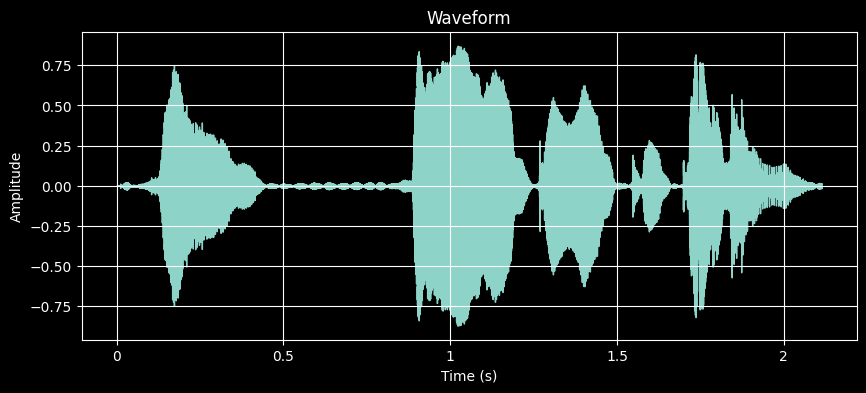

In [18]:
prompt = "Hey, how are you doing today?"
#description = "Jon's voice is monotone yet slightly fast in delivery, with a very close recording that almost has no background noise."
description = "A female speaker delivers a slightly expressive and animated speech with a moderate speed and pitch. The recording is of very high quality, with the speaker's voice sounding clear and very close up."

input_ids = tokenizer(description, return_tensors="pt").input_ids.to(device)
prompt_input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

generation = model.generate(input_ids=input_ids, prompt_input_ids=prompt_input_ids)
audio_arr = generation.cpu().squeeze()

show_waveform(None, waveform=audio_arr, sr=model.config.sampling_rate)

## Total Model

In [ ]:
class MFCCLoss(nn.Module):
    """Loss based on MFCC similarity between generated and target audio"""

    def __init__(self, sample_rate=24000, n_mfcc=40, n_mels=80):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc

        # MFCC transform
        self.mfcc_transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': 1024,
                'hop_length': 256,
                'n_mels': n_mels,
                'center': False
            }
        )

    def extract_mfcc(self, waveform):
        """
        Extract MFCC features from waveform
        Args:
            waveform: (batch_size, n_samples) or (batch_size, 1, n_samples)
        Returns:
            mfcc: (batch_size, n_mfcc, time)
        """
        if waveform.dim() == 3 and waveform.shape[1] == 1:
            waveform = waveform.squeeze(1)
        
        mfcc = self.mfcc_transform(waveform)
        return mfcc

    def forward(self, generated_audio, target_audio):
        """
        Compute MFCC-based loss
        Args:
            generated_audio: (batch_size, n_samples)
            target_audio: (batch_size, n_samples)
        Returns:
            loss: scalar
        """
        # Extract MFCCs
        gen_mfcc = self.extract_mfcc(generated_audio)  # (B, n_mfcc, T1)
        tgt_mfcc = self.extract_mfcc(target_audio)     # (B, n_mfcc, T2)

        # Align temporal dimensions (take minimum length)
        min_time = min(gen_mfcc.shape[-1], tgt_mfcc.shape[-1])
        gen_mfcc = gen_mfcc[..., :min_time]
        tgt_mfcc = tgt_mfcc[..., :min_time]

        # Compute L1 loss (better for audio than L2)
        mfcc_loss = F.l1_loss(gen_mfcc, tgt_mfcc)

        # Optional: Add cosine similarity loss for phase alignment
        gen_flat = gen_mfcc.flatten(1)  # (B, n_mfcc*T)
        tgt_flat = tgt_mfcc.flatten(1)
        cosine_sim = F.cosine_similarity(gen_flat, tgt_flat, dim=1).mean()
        cosine_loss = 1 - cosine_sim

        # Combined loss
        total_loss = mfcc_loss + 0.1 * cosine_loss

        return total_loss, {
            'mfcc_l1': mfcc_loss.item(),
            'cosine_loss': cosine_loss.item(),
            'total': total_loss.item()
        }

In [20]:
config.audio_encoder.sampling_rate

44100

In [ ]:
mfcc_loss_fn = MFCCLoss(sample_rate=config.audio_encoder.sampling_rate).to(device)

In [ ]:
class TargetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.clap_model = clap_model
        self.clap_processor = clap_processor
        self.hypernetwork = hypernetwork
        self.peft_model = peft_model
        self.base_tokenizer = base_tokenizer
        self.device = torch.device("cpu")

    def forward(self, voice_descriptions, input_texts, target_audios=None):
        """
        Forward pass with MFCC-based loss
        Args:
            voice_descriptions: list of strings describing voice style
            input_texts: list of strings to synthesize
            target_audios: (batch_size, n_samples) target audio waveforms
        Returns:
            dict with loss and generated audios
        """
        # Generate audio
        generated_audios, lora_weights = self.generate_audio(input_texts, voice_descriptions)
        
        # If training, compute loss
        if target_audios is not None and self.training:
            # Stack generated audios
            # Need to pad/trim to same length
            max_len = max(audio.shape[-1] for audio in generated_audios)
            padded_gen = []
            for audio in generated_audios:
                if audio.shape[-1] < max_len:
                    padding = max_len - audio.shape[-1]
                    audio = F.pad(audio, (0, padding))
                else:
                    audio = audio[..., :max_len]
                padded_gen.append(audio)

            gen_batch = torch.stack(padded_gen).to(target_audios.device)

            # Align target audio length
            if target_audios.shape[-1] != max_len:
                if target_audios.shape[-1] < max_len:
                    padding = max_len - target_audios.shape[-1]
                    target_audios = F.pad(target_audios, (0, padding))
                else:
                    target_audios = target_audios[..., :max_len]

            # Compute MFCC loss
            loss, loss_dict = mfcc_loss_fn(gen_batch, target_audios)

            return {
                'loss': loss,
                'loss_dict': loss_dict,
                'generated_audios': generated_audios,
                'lora_weights': lora_weights
            }
        else:
            return {
                'generated_audios': generated_audios,
                'lora_weights': lora_weights
            }

In [ ]:
voice_model = T2ALoRAModel(clap_model, clap_processor, hypernetwork, peft_model, base_tokenizer)
voice_model.to(device)

## Training

In [ ]:
# Training hyperparameters
BATCH_SIZE = 2  # Reduced due to audio generation overhead
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
WARMUP_STEPS = 500
SAVE_STEPS = 500
LOG_STEPS = 50
OUTPUT_DIR = "./t2a_lora_mfcc_checkpoints"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Create DataLoader
train_dataloader = DataLoader(
    datasets,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: x
)

print(f"Total training batches: {len(train_dataloader)}")

In [ ]:
# Optimizer - only train hypernetwork
optimizer = AdamW(
    hypernetwork.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Learning rate scheduler
total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=total_steps,
    eta_min=1e-6
)

print(f"Optimizer configured: {sum(p.numel() for p in hypernetwork.parameters()):,} trainable parameters")

In [ ]:
DUMMY = "A female speaker delivers a slightly expressive and animated speech with a moderate speed and pitch. The recording is of very high quality, with the speaker's voice sounding clear and very close up."

In [ ]:
# Training loop with MFCC-based loss
global_step = 0
best_loss = float('inf')

print("Starting MFCC-based training...\n")
print("Strategy: Compare generated audio vs target audio using MFCC features")
print("Goal: LoRA learns to modify voice style while preserving content\n")

for epoch in range(NUM_EPOCHS):
    voice_model.train()
    epoch_loss = 0
    epoch_mfcc_l1 = 0
    epoch_cosine = 0
    
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for batch_idx, batch in enumerate(pbar):
        batch_loss = 0
        batch_mfcc_l1 = 0
        batch_cosine = 0
        
        # Process each sample individually (no batching for generation)
        for item in batch:
            voice_description = item['style_prompt']
            input_text = item['content_prompt']
            target_audio = item['audio'].to(device)
            
            # Ensure target is 1D
            if target_audio.dim() > 1:
                target_audio = target_audio.squeeze()
            
            # Get CLAP embeddings
            clap_embeds = voice_model.get_clap_embeddings([voice_description])
            
            # Generate LoRA weights
            lora_weights = hypernetwork(clap_embeds)
            
            # Apply LoRA weights (single sample)
            voice_model.apply_lora_weights(lora_weights, batch_idx=0)
            
            # Tokenize input text
            inputs = base_tokenizer(
                [input_text],
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(device)
            style_inputs = base_tokenizer(DUMMY, return_tensors="pt", padding=True).to(device)

            # Generate audio
            generation = peft_model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                prompt_input_ids=style_inputs.input_ids,
                prompt_attention_mask=style_inputs.attention_mask,
                do_sample=True,
                temperature=1.0,
                max_length=2000,
            )
            
            # Decode to audio
            audio_arr = generation.squeeze().cpu().numpy()
            generated_audio = torch.from_numpy(audio_arr).squeeze().to(device)
            
            # Align lengths for MFCC comparison
            min_len = min(generated_audio.shape[-1], target_audio.shape[-1])
            gen_audio_aligned = generated_audio[..., :min_len]
            tgt_audio_aligned = target_audio[..., :min_len]
            
            # Add batch dimension for loss function
            gen_batch = gen_audio_aligned.unsqueeze(0)
            tgt_batch = tgt_audio_aligned.unsqueeze(0)
            
            # Compute MFCC loss
            loss, loss_dict = mfcc_loss_fn(gen_batch, tgt_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            nn.utils.clip_grad_norm_(hypernetwork.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate losses
            batch_loss += loss.item()
            batch_mfcc_l1 += loss_dict['mfcc_l1']
            batch_cosine += loss_dict['cosine_loss']
        
        # Average losses over batch
        if len(batch) > 0:
            batch_loss /= len(batch)
            batch_mfcc_l1 /= len(batch)
            batch_cosine /= len(batch)
            
            epoch_loss += batch_loss
            epoch_mfcc_l1 += batch_mfcc_l1
            epoch_cosine += batch_cosine
            
            scheduler.step()
            global_step += 1
            
            pbar.set_postfix({
                'loss': f"{batch_loss:.4f}",
                'mfcc_l1': f"{batch_mfcc_l1:.4f}",
                'cosine': f"{batch_cosine:.4f}",
                'lr': f"{scheduler.get_last_lr()[0]:.2e}"
            })
            
            # Periodic logging
            if global_step % LOG_STEPS == 0:
                avg_loss = epoch_loss / (batch_idx + 1)
                avg_mfcc = epoch_mfcc_l1 / (batch_idx + 1)
                avg_cosine = epoch_cosine / (batch_idx + 1)
                print(f"\nStep {global_step}:")
                print(f"  Avg Total Loss: {avg_loss:.4f}")
                print(f"  Avg MFCC L1: {avg_mfcc:.4f}")
                print(f"  Avg Cosine: {avg_cosine:.4f}")
            
            # Save checkpoint
            if global_step % SAVE_STEPS == 0:
                checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint-{global_step}")
                os.makedirs(checkpoint_path, exist_ok=True)
                
                torch.save({
                    'epoch': epoch,
                    'global_step': global_step,
                    'hypernetwork_state_dict': hypernetwork.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'avg_loss': avg_loss,
                }, os.path.join(checkpoint_path, 'model.pt'))
                
                print(f"\nCheckpoint saved at step {global_step}")
    
    # End of epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    avg_epoch_mfcc = epoch_mfcc_l1 / len(train_dataloader)
    avg_epoch_cosine = epoch_cosine / len(train_dataloader)
    
    print(f"\nEpoch {epoch+1} completed:")
    print(f"  Average Total Loss: {avg_epoch_loss:.4f}")
    print(f"  Average MFCC L1: {avg_epoch_mfcc:.4f}")
    print(f"  Average Cosine: {avg_epoch_cosine:.4f}")
    
    # Save best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_model_path = os.path.join(OUTPUT_DIR, "best_model")
        os.makedirs(best_model_path, exist_ok=True)
        
        torch.save({
            'epoch': epoch,
            'hypernetwork_state_dict': hypernetwork.state_dict(),
            'best_loss': best_loss,
        }, os.path.join(best_model_path, 'model.pt'))
        
        print(f"Best model saved with loss: {best_loss:.4f}")

print("\nTraining completed!")

## Test

In [ ]:
# Load best model for inference
def load_best_model():
    best_model_path = os.path.join(OUTPUT_DIR, "best_model", "model.pt")
    checkpoint = torch.load(best_model_path)
    hypernetwork.load_state_dict(checkpoint['hypernetwork_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with loss {checkpoint['best_loss']:.4f}")

In [ ]:
# load_best_model()
voice_model.eval()

In [ ]:
# Test inference
test_voice_desc = ["A clear, young female voice with a British accent"]
test_text = ["Hello, this is a test of the dynamic voice adaptation system."]

with torch.no_grad():
    outputs = voice_model(
        voice_descriptions=test_voice_desc,
        input_texts=test_text,
        target_audios=None
    )
    
    generated_audio = outputs['generated_audios'][0]

print("Inference completed successfully!")
print(f"Generated audio shape: {generated_audio.shape}")

# Play generated audio
Audio(generated_audio.cpu().numpy(), rate=24000)

In [ ]:
# Visualize MFCC comparison
def visualize_mfcc_comparison(generated, target, sr=24000):
    """Visualize MFCC features of generated vs target audio"""
    mfcc_transform = T.MFCC(
        sample_rate=sr,
        n_mfcc=40,
        melkwargs={'n_fft': 1024, 'hop_length': 256, 'n_mels': 80}
    )
    
    # Ensure same length
    min_len = min(generated.shape[-1], target.shape[-1])
    gen = generated[..., :min_len]
    tgt = target[..., :min_len]
    
    # Compute MFCCs
    gen_mfcc = mfcc_transform(gen.unsqueeze(0)).squeeze(0).cpu().numpy()
    tgt_mfcc = mfcc_transform(tgt.unsqueeze(0)).squeeze(0).cpu().numpy()
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    im1 = axes[0].imshow(gen_mfcc, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title('Generated Audio MFCC')
    axes[0].set_ylabel('MFCC Coefficient')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(tgt_mfcc, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_title('Target Audio MFCC')
    axes[1].set_ylabel('MFCC Coefficient')
    axes[1].set_xlabel('Time Frame')
    plt.colorbar(im2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

# Test with a sample
sample = datasets[0]
test_desc = [sample['style_prompt']]
test_txt = [sample['content_prompt']]

with torch.no_grad():
    out = voice_model(
        voice_descriptions=test_desc,
        input_texts=test_txt,
        target_audios=None
    )
    gen_audio = out['generated_audios'][0]

visualize_mfcc_comparison(gen_audio.cpu(), sample['audio'], sr=24000)